In [1]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import dfols
import signal
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy import interpolate, integrate
from stopit import threading_timeoutable as timeoutable
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from batfuns import *
plt.rcParams = set_rc_params(plt.rcParams)
import winsound
from pybamm import exp, constants, Parameter
import pickle
eSOH_DIR = "../data/esoh_R/"
oCV_DIR = "../data/ocv/"
cyc_DIR = "../data/cycling/"
fig_DIR = "../figures/figures_paper/"
res_DIR = "../data/results_paper/"
resistance_DIR = "../data/resistance/"
%matplotlib widget

In [2]:
parameter_values = get_parameter_values()

spm = pybamm.lithium_ion.SPM(
    {
        "SEI": "ec reaction limited",
        "loss of active material": "stress-driven",
        "lithium plating": "irreversible",
        "stress-induced diffusion": "false",
    }
)
# spm.print_parameter_info()
param=spm.param

In [3]:
cell = 5
sno = 7
sim_des = f'cond{sno}'
sim_des = sim_des+'_sc_2'

cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
Ns = np.insert(N[1:]-1,0,0)
eps_n_data,eps_p_data,c_rate_c,c_rate_d,dis_set,Temp,SOC_0 = init_exp(cell_no,dfe,spm,parameter_values)
print(cell_no)
pybamm.set_logging_level("WARNING")
# pybamm.set_logging_level("NOTICE")
experiment = pybamm.Experiment(
    [
        ("Discharge at "+c_rate_d+dis_set,
        "Rest for 10 sec",
        "Charge at "+c_rate_c+" until 4.2V", 
        "Hold at 4.2V until C/100")
    # ] *dfe.N.iloc[-1],
    ] *40,
    termination="50% capacity",
#     cccv_handling="ode",
)
par_val = {}
# Previous i.e. tuning mech sim sep and then Li plating
par_val[0]=[1.2715e-07,1.2727e-06,1.1992,1.353e-9]
# Using only C/5 and 1.5C Cycling aging, cost function with Cn,Cp,x100,y0
par_val[1]=[1.4819e-07,1.5114e-06,1.2484,1.4732e-09]
# Using only C/5 and 1.5C Cycling aging, cost function with Cn,Cp,C,LLI(%)
par_val[2]=[1.4493e-07,1.3608e-06,1.199,1.2138e-09]
# Using C/5, 1.5C and mixed c-rate (Ch:C/5, Dh:1.5C) Cycling aging, cost function with Cn,Cp,x100,y0
par_val[3]=[1.043e-07,1.036e-06,1.208,1.6045e-09]
# Using C/5, 1.5C and mixed c-rate (Ch:C/5, Dh:1.5C) Cycling aging, cost function with Cn,Cp,C,LLI(%)
par_val[4]=[8.755e-08,8.572e-07,1.135,1.5788e-09]
# Using C/5, 1.5C and mixed c-rate (Ch:C/5, Dh:1.5C) Cycling aging, cost function with Cn,Cp,C,LLI(%) another initial condition
par_val[5]=[8.7698e-08,8.5848e-07,1.1354,1.5778e-09]
# New Mech Damage Model
par_val[6]=[2.056E-07,2.4664E-06,1.2468,1.0482e-09]
# New Mech Damage Model with Lithium plating resistane
par_val[7]=[2.190e-07,2.308e-06,1.214,2.537e-09]
parameter_values = get_parameter_values()
parameter_values.update(
    {
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
        "Initial temperature [K]": 273.15+Temp,
        "Ambient temperature [K]": 273.15+Temp,
        # "Initial temperature [K]": 273.15+25,
        # "Ambient temperature [K]": 273.15+25,
        "Positive electrode LAM constant proportional term [s-1]": par_val[sno][0],
        "Negative electrode LAM constant proportional term [s-1]": par_val[sno][1],
        "Positive electrode LAM constant exponential term": par_val[sno][2],
        "Negative electrode LAM constant exponential term": par_val[sno][2],
        "SEI kinetic rate constant [m.s-1]":  4.60788219e-16, #1.08494281e-16 , 
        "EC diffusivity [m2.s-1]": 4.56607447e-19,#8.30909086e-19,
        "SEI growth activation energy [J.mol-1]": 1.87422275e+04,#1.58777981e+04,
        "Lithium plating kinetic rate constant [m.s-1]": par_val[sno][3],
        "Initial inner SEI thickness [m]": 0e-09,
        "Initial outer SEI thickness [m]": 5e-09,
        "SEI resistivity [Ohm.m]": 30000.0,
        "Positive electrode critical stress [Pa]": 0.75*375e6,
        "Negative electrode critical stress [Pa]": 0.5*60e6,
        "Positive electrode reference exchange-current density activation energy [J.mol-1]": 0,
        "Positive electrode diffusion coefficient activation energy [J.mol-1]": 0,
        "Negative electrode reference exchange-current density activation energy [J.mol-1]": 0,
        "Negative electrode diffusion coefficient activation energy [J.mol-1]": 0,
        "Negative electrode reference exchange-current density [A.m-2(m3.mol)1.5]": 1.4*3.183e-06,
        "Positive electrode reference exchange-current density [A.m-2(m3.mol)1.5]": 1.26*3.377e-06,
        "Positive electrode OCP entropic change [V.K-1]":0,
        "Negative electrode OCP entropic change [V.K-1]":0,
    },
    check_already_exists=False,
)
all_sumvars_dict = cycle_adaptive_simulation(spm, parameter_values, experiment,SOC_0=0.99, save_at_cycles=1)

05


In [4]:
def load_cycling_data_ch(cell,eSOH_DIR,oCV_DIR,cyc_DIR,cyc_no):
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    cycles = np.array(dfe_0['N'].astype('int'))+1
    cycles = cycles[1:]
    # print(cell_no)
    cyc_data_raw1 = pd.read_csv(cyc_DIR+'cycling_data_cell_'+cell_no+'.csv')
    if cell == 1:
        offset = 12
    # elif cell == 9:
    #     offset = 2
    else:
        offset = 0
    if len(cycles) == cyc_no+1:
        N1 = cyc_data_raw1["Cycle number"].iloc[-1]-offset
    else:
        N1 = cycles[cyc_no]
    # print(N1)
    cyc_data_raw = cyc_data_raw1[ cyc_data_raw1['Cycle number'] == N1 ]
    cyc_data = cyc_data_raw.reset_index(drop=True)
    t_c1 = cyc_data['Time [s]']-cyc_data['Time [s]'][0]
    t_c1 = t_c1.values
    I_c1 = cyc_data['Current [mA]']/1000
    I_c1 = I_c1.values
    V_c1 = cyc_data['Voltage [V]']
    V_c1 = V_c1.values
    E_c1 = cyc_data["Expansion [mu m]"]
    E_c1 = E_c1.values
    idx_I = np.where(np.sign(I_c1[:-1]) != np.sign(I_c1[1:]))[0] 
    idx_I = idx_I[idx_I>50]
    t = t_c1[:idx_I[0]]
    V = V_c1[:idx_I[0]]
    I = I_c1[:idx_I[0]]
    E = E_c1[:idx_I[0]]-E_c1[0]
    # t = t_c1
    # V = V_c1
    # I = I_c1
    Q = integrate.cumtrapz(I,t, initial=0)/3600 #Ah
    
    return t,V,I,Q,E


In [5]:
dis_set = " until 3V"

if c_rate_d=="C/5":
    timestep = '20 sec'
else:
    timestep = '5 sec'

experiment_cyc_comp_ch = pybamm.Experiment(
    [
        "Discharge at "+c_rate_d+dis_set,
        "Rest for 10 sec",
        "Charge at "+c_rate_c+" until 4.2V", 
        "Hold at 4.2V until C/100",
        # "Rest for 10 sec",
        # "Discharge at "+c_rate_d+dis_set,
    ],
    period=timestep,
)
Ns = np.insert(N[1:]-1,0,0)

In [6]:
def cyc_comp_ch(cyc_no,eSOH,t_d,Q_d,V_d,E_d,parameter_values):
    # dfo = dfo_0[dfo_0['N']==N[cyc_no]]
    model = spm
    Vmin = 3.0
    Vmax = 4.2
    esoh_model = pybamm.lithium_ion.ElectrodeSOH()
    esoh_sim = pybamm.Simulation(esoh_model, parameter_values=parameter_values)
    param = model.param
    Cn = eSOH["C_n"][Ns[cyc_no]]
    # print(Cn)
    Cp = eSOH["C_p"][Ns[cyc_no]]
    c_n_max = parameter_values.evaluate(param.n.prim.c_max)
    c_p_max = parameter_values.evaluate(param.p.prim.c_max)
    n_Li_init = eSOH["Total lithium in particles [mol]"][Ns[cyc_no]]
    eps_n_data = parameter_values.evaluate(Cn*3600/(param.n.L * param.n.prim.c_max * param.F* param.A_cc))
    eps_p_data = parameter_values.evaluate(Cp*3600/(param.p.L * param.p.prim.c_max * param.F* param.A_cc))
    del_sei = eSOH['X-averaged SEI thickness [m]'][Ns[cyc_no]]
    c_plated_Li = eSOH['X-averaged lithium plating concentration [mol.m-3]'][Ns[cyc_no]]
    esoh_sol = esoh_sim.solve(
        [0],
        inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li_init},
        solver=pybamm.AlgebraicSolver(),
    )

    parameter_values.update(
        {
    #         "Initial concentration in negative electrode [mol.m-3]": esoh_sol[
    #    "x_100"
    #         ].data[0]
    #         * c_n_max,
    #         "Initial concentration in positive electrode [mol.m-3]": esoh_sol[
    #             "y_100"
    #         ].data[0]
    #         * c_p_max,
            "Negative electrode active material volume fraction": eps_n_data,
            "Positive electrode active material volume fraction": eps_p_data,
            "Initial temperature [K]": 273.15+Temp,
            "Ambient temperature [K]": 273.15+Temp,
            "Initial inner SEI thickness [m]": 0e-09,
            # "Initial outer SEI thickness [m]": 5e-09,
            "Initial outer SEI thickness [m]": del_sei,
            "Initial plated lithium concentration [mol.m-3]": c_plated_Li,        
        }
    )

    sim_exp = pybamm.Simulation(
        model, experiment=experiment_cyc_comp_ch, parameter_values=parameter_values,
        solver=pybamm.CasadiSolver(mode="safe", rtol=1e-6, atol=1e-6,dt_max=0.1),
    )
    sol_exp = sim_exp.solve()
    t_t = sol_exp["Time [s]"].entries
    I_t = sol_exp["Current [A]"].entries
    Q_t = -sol_exp['Discharge capacity [A.h]'].entries
    Vt_t = sol_exp["Terminal voltage [V]"].entries
    exp_t = 30e6*sol_exp["Cell thickness change [m]"].entries
    idx = np.where(np.diff(np.sign(-I_t)))[0]
    I = I_t[idx[0]:]
    t = t_t[idx[0]:]-t_t[idx[0]]
    Q = Q_t[idx[0]:]-Q_t[idx[0]]
    Vt = Vt_t[idx[0]:]
    Exp = exp_t[idx[0]:]-exp_t[idx[0]]

    if max(t)<max(t_d):
        int_V = interpolate.CubicSpline(t_d,V_d,extrapolate=True)
        rmse_V = pybamm.rmse(Vt,int_V(t))
        int_E = interpolate.CubicSpline(t_d,E_d,extrapolate=True)
        rmse_E = pybamm.rmse(Exp,int_E(t))
        # int_VQ = interpolate.CubicSpline(Q_d,V_d,extrapolate=True)
        # rmse_VQ = pybamm.rmse(Vt,int_VQ(Q))
        # int_EQ = interpolate.CubicSpline(Q_d,E_d,extrapolate=True)
        # rmse_EQ = pybamm.rmse(Exp,int_EQ(Q))
    else:
        int_V = interpolate.CubicSpline(t,Vt,extrapolate=True)
        rmse_V = pybamm.rmse(V_d,int_V(t_d))
        int_E = interpolate.CubicSpline(t,Exp,extrapolate=True)
        rmse_E = pybamm.rmse(E_d,int_E(t_d))
        # int_VQ = interpolate.CubicSpline(Q[1:],Vt[1:],extrapolate=True)
        # rmse_VQ = pybamm.rmse(V_d,int_VQ(Q_d))
        # int_EQ = interpolate.CubicSpline(Q[1:],Exp[1:],extrapolate=True)
        # rmse_EQ = pybamm.rmse(E_d,int_EQ(Q_d))
    # rmse_V =0
    # max_V = 0
    rmse_VQ  = 0 ; rmse_EQ = 0
    return t,I,Q,Vt,Exp,sol_exp,rmse_V,rmse_E,rmse_VQ,rmse_EQ

# Voltage Plots

0


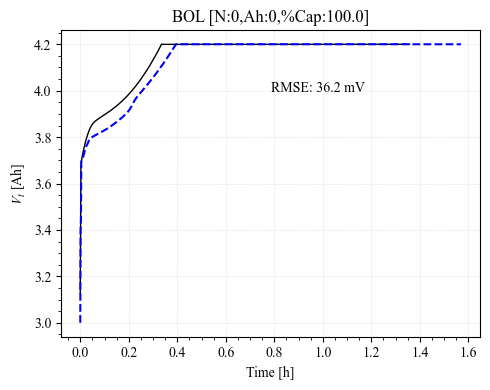

In [11]:
cyc_no=0
# cyc_no=len(N)-1
i=0
titles = ["BOL","MOL","EOL"]
fig, ax = plt.subplots(1,1,figsize=(5,4))
print(cyc_no)
t_d,V_d,I_d,Q_d,E_d = load_cycling_data_ch(cell,eSOH_DIR,oCV_DIR,cyc_DIR,cyc_no)
parameter_values.update(
{
    "Positive electrode LAM constant proportional term [s-1]": par_val[2][0],
    "Negative electrode LAM constant proportional term [s-1]": par_val[2][1],
    "Positive electrode LAM constant exponential term": par_val[2][2],
    "Negative electrode LAM constant exponential term": par_val[2][2],
    "Lithium plating kinetic rate constant [m.s-1]": par_val[2][3],
    "SEI resistivity [Ohm.m]": 30000.0,
    "Negative electrode reference exchange-current density [A.m-2(m3.mol)1.5]": 0.2*3.183e-06,
    "Positive electrode reference exchange-current density [A.m-2(m3.mol)1.5]": 0.2*3.377e-06,
    "Negative electrode diffusion coefficient [m2.s-1]": 0.3*8e-14,
    "Positive electrode diffusion coefficient [m2.s-1]": 0.3*8e-15,

},
check_already_exists=False,
)
t,I,Q,Vt,Exp,sol,rmse_V,rmse_E,rmse_VQ,rmse_EQ = cyc_comp_ch(cyc_no,all_sumvars_dict,t_d,Q_d,V_d,E_d,parameter_values)
# if cyc_no in [0,int((len(N)+1)/2),len(N)-3]:
ax1 = ax
ax1.plot(t_d/3600,V_d,'k',linewidth=1)
ax1.plot(t/3600,Vt,'b--',linewidth=1.5)
ax1.set_xlabel('Time [h]')
# ax1.set_xlabel('Q [Ah]')
ax1.text(0.5,0.8,f'RMSE: {rmse_V*1e3:0.1f} mV',transform=ax1.transAxes)
ax1.set_ylabel('$V_t$ [Ah]')
ax1.set_title('{} [N:{:0.0f},Ah:{:0.0f},%Cap:{:0.1f}]'.format(titles[i],N[cyc_no],dfe['Ah_th'][cyc_no],(dfe["Cap"][cyc_no]/dfe["Cap"][0])*100))
i+=1
# fig.suptitle('Cycling Voltage Discharge')
fig.tight_layout()
# plt.savefig(fig_DIR +'volt_error_cell_'+cell_no+'_dh_t.png')

In [8]:
sdfsdf

NameError: name 'sdfsdf' is not defined

In [ ]:
cyc_no=0
# cyc_no=len(N)-1
titles = ["BOL","MOL","EOL"]
i = 0
fig, ax = plt.subplots(2,3,figsize=(10,6))
for cyc_no in [0,int((len(N)+1)/2),len(N)-1]:
    print(cyc_no)
    t_d,V_d,I_d,Q_d,E_d = load_cycling_data_ch(cell,eSOH_DIR,oCV_DIR,cyc_DIR,cyc_no)
    parameter_values.update(
    {
        "Positive electrode LAM constant proportional term [s-1]": par_val[2][0],
        "Negative electrode LAM constant proportional term [s-1]": par_val[2][1],
        "Positive electrode LAM constant exponential term": par_val[2][2],
        "Negative electrode LAM constant exponential term": par_val[2][2],
        "Lithium plating kinetic rate constant [m.s-1]": par_val[2][3],
        "SEI resistivity [Ohm.m]": 30000.0,
    },
    check_already_exists=False,
    )
    t,I,Q,Vt,Exp,sol,rmse_V,rmse_E,rmse_VQ,rmse_EQ = cyc_comp_ch(cyc_no,all_sumvars_dict,t_d,Q_d,V_d,E_d,parameter_values)
    ax1 = ax.flat[i]
    ax1.plot(t_d/3600,V_d,'k',linewidth=1)
    ax1.plot(t/3600,Vt,'r--',linewidth=1.5)
    ax1.set_xlabel('Time [h]')
    ax1.text(0.5,0.2,f'RMSE: {rmse_V*1e3:0.1f} mV',transform=ax1.transAxes)
    ax1.set_ylabel('$V_t$ [Ah]')
    ax1.set_title('{} [N:{:0.0f},Ah:{:0.0f},%Cap:{:0.1f}]'.format(titles[i],N[cyc_no],dfe['Ah_th'][cyc_no],(dfe["Cap"][cyc_no]/dfe["Cap"][0])*100))
    ax2 = ax.flat[i+3]
    ax2.plot(t_d/3600,I_d,'k',linewidth=1)
    ax2.plot(t/3600,-I,'r--',linewidth=1.5)
    ax2.set_xlabel('Time [h]')
    ax2.set_ylim(bottom=0)
    ax2.set_ylabel('$I$ [A]')
    i+=1
ax2.legend(["Data","Sim"])
# fig.suptitle('Cycling Voltage Charge')
fig.tight_layout()
plt.savefig(fig_DIR +'volt_error_cell_'+cell_no+'_ch_t.png')
# plt.savefig(fig_DIR +'volt_error_cell_'+cell_no+'_ch_Q.png')

# Tune Parameters

In [ ]:
czxc

In [48]:
def cyc_comp_ch_fresh(eSOH,t_d,V_d,parameter_values,experiment_cyc_comp_ch):
    # dfo = dfo_0[dfo_0['N']==N[cyc_no]]
    model = spm
    Vmin = 3.0
    Vmax = 4.2
    esoh_model = pybamm.lithium_ion.ElectrodeSOH()
    esoh_sim = pybamm.Simulation(esoh_model, parameter_values=parameter_values)
    param = model.param
    Cn = eSOH["C_n"][0]
    # print(Cn)
    Cp = eSOH["C_p"][0]
    c_n_max = parameter_values.evaluate(param.n.prim.c_max)
    c_p_max = parameter_values.evaluate(param.p.prim.c_max)

    parameter_values.update(
        {
            "Initial inner SEI thickness [m]": 0e-09,
            "Initial outer SEI thickness [m]": 5e-09,
            "Initial plated lithium concentration [mol.m-3]": 0,        
        }
    )

    sim_exp = pybamm.Simulation(
        model, experiment=experiment_cyc_comp_ch, parameter_values=parameter_values,
        solver=pybamm.CasadiSolver(mode="safe", rtol=1e-6, atol=1e-6,dt_max=0.1),
    )
    sol_exp = sim_exp.solve(initial_soc=1)
    t_t = sol_exp["Time [s]"].entries
    I_t = sol_exp["Current [A]"].entries
    Q_t = -sol_exp['Discharge capacity [A.h]'].entries
    Vt_t = sol_exp["Terminal voltage [V]"].entries
    exp_t = 30e6*sol_exp["Cell thickness change [m]"].entries
    idx = np.where(np.diff(np.sign(-I_t)))[0]
    I = I_t[idx[0]:]
    t = t_t[idx[0]:]-t_t[idx[0]]
    Q = Q_t[idx[0]:]-Q_t[idx[0]]
    Vt = Vt_t[idx[0]:]
    if max(t)<max(t_d):
        int_V = interpolate.CubicSpline(t_d,V_d,extrapolate=True)
        rmse_V = pybamm.rmse(Vt,int_V(t))
    else:
        int_V = interpolate.CubicSpline(t,Vt,extrapolate=True)
        rmse_V = pybamm.rmse(V_d,int_V(t_d))
    return t,I,Vt,rmse_V

In [49]:
def model_error(cell,parameter_values,plot_bool=False):
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    eps_n_data,eps_p_data,c_rate_c,c_rate_d,dis_set,Temp,SOC_0 = init_exp(cell_no,dfe,spm,parameter_values)
    parameter_values.update(
        {
            "Negative electrode active material volume fraction": eps_n_data,
            "Positive electrode active material volume fraction": eps_p_data,
            "Initial temperature [K]": 273.15+Temp,
            "Ambient temperature [K]": 273.15+Temp,
        },
        check_already_exists=False,
    )
    dis_set = " until 3V"
    if c_rate_d=="C/5":
        timestep = '60 sec'
    else:
        timestep = '10 sec'
        
    experiment_cyc_comp_ch = pybamm.Experiment(
        [
            "Discharge at "+c_rate_d+dis_set,
            "Rest for 10 sec",
            "Charge at "+c_rate_c+" until 4.2V", 
            "Hold at 4.2V until C/100",
        ],
        period=timestep,
    )
    t_d,V_d,I_d,Q_d,E_d = load_cycling_data_ch(cell,eSOH_DIR,oCV_DIR,cyc_DIR,cyc_no)
    t,I,Vt,rmse_V = cyc_comp_ch_fresh(dfe,t_d,V_d,parameter_values,experiment_cyc_comp_ch)
    if plot_bool:
        fig, ax = plt.subplots(2, 1, figsize=(5, 8), sharex=True)
        ax1 = ax.flat[0]
        ax1.plot(t_d, V_d, 'k')
        ax1.plot(t, Vt, 'b--')
        ax1.text(0.7,0.2,f'RMSE: {rmse_V*1e3:0.1f} mV',transform=ax1.transAxes)
        # ax1.plot(t1, V1, 'r-.')
        ax1.set_ylabel("Voltage [V]")
        # ax1.set_title("Cell 01 Fresh HPPC")
        ax1.set_ylim([3,4.21])
        ax1.set_xlabel("Time [s]")
        # ax1.set_xlim([20370,20470])
        ax1.legend(['data','sim'])
        ax2 = ax.flat[1]
        ax2.plot(t_d, I_d, 'k')
        ax2.plot(t, -I, 'b--')
        fig.tight_layout()
        plt.show()
    return rmse_V

In [50]:
def prediction_error(x):
    try:
        parameter_values.update(
            {
                "Negative electrode reference exchange-current density [A.m-2(m3.mol)1.5]": 3.183e-06,#x[0]*
                "Positive electrode reference exchange-current density [A.m-2(m3.mol)1.5]":	3.377e-06,#x[1]*
                "Negative electrode diffusion coefficient [m2.s-1]": 8e-14,#x[2]*
                "Positive electrode diffusion coefficient [m2.s-1]": 8e-15,#x[3]*
                "Negative electrode diffusion coefficient activation energy [J.mol-1]":x[0]*10e3,
                "Negative electrode reference exchange-current density activation energy [J.mol-1]": x[1]*10e3,
                "Positive electrode diffusion coefficient activation energy [J.mol-1]": x[2]*10e3,
                "Positive electrode reference exchange-current density activation energy [J.mol-1]": x[3]*10e3,
                # "SEI kinetic rate constant [m.s-1]": 1.6827e-16,
                # "EC diffusivity [m2.s-1]": 2e-18,
                # "SEI growth activation energy [J.mol-1]": 0,
            },
            check_already_exists=False,
        )
        out = 0
        for cell in [2,3,5,6]:
            rmse_V=model_error(cell,parameter_values)
            out_t = rmse_V
            out+=out_t
        out = np.array([out])
        print(f"x={x}, norm={np.linalg.norm(out)}")
    # except pybamm.SolverError:
    # except:
    except Exception as e: 
        print(e)
        out = 5
        out = np.array([out])
        print(f"x={x}, norm={np.linalg.norm(out)}")
        return out
    return out
def train_model():
    timer = pybamm.Timer()
    x0 = np.array([2,2,2,2])
    lower = np.array([1e+0, 1e+0, 1e+0, 1e+0])
    upper = np.array([1e+1, 1e+1, 1e+1, 1e+1])
    # x0 = np.array([3,3])
    # lower = np.array([1e+0, 1e+0])
    # upper = np.array([5e+0, 5e+0])
    dfo_opts = {
        "init.random_initial_directions":True,
        "init.run_in_parallel": True,
    }
    soln_dfols = dfols.solve(prediction_error, x0,bounds=(lower, upper), rhoend=1e-2, user_params=dfo_opts)
    # print(prediction_error(x0))
    # soln_dfols = dfols.solve(prediction_error, x0, rhoend=1e-3)
    print(timer.time())
    return soln_dfols

In [51]:
soln_dfols = train_model()

x=[2. 2. 2. 2.], norm=0.25820285851761704
x=[1.89199507 2.0034616  1.83241704 2.01545654], norm=0.2641847094384182
x=[2.16218425 1.9947461  1.89137766 1.95675819], norm=0.2595630784171754
x=[2.03233798 2.15746093 1.99336943 2.11881222], norm=0.25439434813146444
x=[2.03139205 1.87684779 1.99144579 2.1541911 ], norm=0.2589192501206736
x=[2.10484733 2.25039768 2.14925002 2.16131396], norm=0.24690948382766367
x=[2.39437283 2.6309793  2.76544215 2.33918998], norm=0.21522610684967797
x=[3.54080404 4.28974161 5.10574551 3.17416499], norm=0.18643003177277012
x=[4.30979452 3.51124201 7.91689729 2.10644888], norm=0.3554243881212988
x=[3.90010648 4.10330794 5.02038237 3.34412585], norm=0.18722082327782907
x=[3.45128568 5.38815297 4.48759282 4.15567718], norm=0.18575704591287606
x=[3.19997797 5.14533164 4.61378457 4.48397349], norm=0.18798245054579177
x=[3.21225847 5.1352543  3.78810869 3.98354291], norm=0.16971158726430383
x=[3.00405257 4.98187801 3.07957386 3.7168888 ], norm=0.154000395410749
x=

In [52]:
x = soln_dfols.x

In [54]:
# x = np.array([2.69,2.97,3,3])
# x = np.array([1.5,1.5,1.5,1.5])
# x = np.array([0.2,0.2,0.25,0.1])
# x = np.array([1,1,1,1])
x

array([3.27585612, 5.31668278, 2.96095657, 3.46826355])

In [55]:
parameter_values.update(
    {
        "Negative electrode reference exchange-current density [A.m-2(m3.mol)1.5]": 3.183e-06,#x[0]*
        "Positive electrode reference exchange-current density [A.m-2(m3.mol)1.5]":	3.377e-06,#x[1]*
        "Negative electrode diffusion coefficient [m2.s-1]": 8e-14,#x[2]*
        "Positive electrode diffusion coefficient [m2.s-1]": 8e-15,#x[3]*
        "Positive electrode OCP entropic change [V.K-1]":0,
        "Negative electrode OCP entropic change [V.K-1]":0,
        # "Negative electrode diffusion coefficient activation energy [J.mol-1]":35e3,
        # "Negative electrode reference exchange-current density activation energy [J.mol-1]": 20e3,
        # "Positive electrode diffusion coefficient activation energy [J.mol-1]": 25e3,
        # "Positive electrode reference exchange-current density activation energy [J.mol-1]": 30e3,
        "Negative electrode diffusion coefficient activation energy [J.mol-1]":x[0]*10e3,
        "Negative electrode reference exchange-current density activation energy [J.mol-1]": x[1]*10e3,
        "Positive electrode diffusion coefficient activation energy [J.mol-1]": x[2]*10e3,
        "Positive electrode reference exchange-current density activation energy [J.mol-1]": x[3]*10e3,
    },
    check_already_exists=False,
)

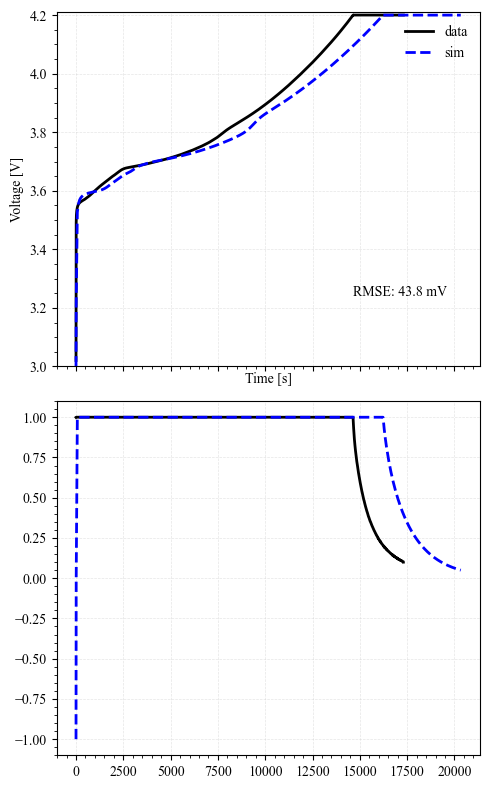

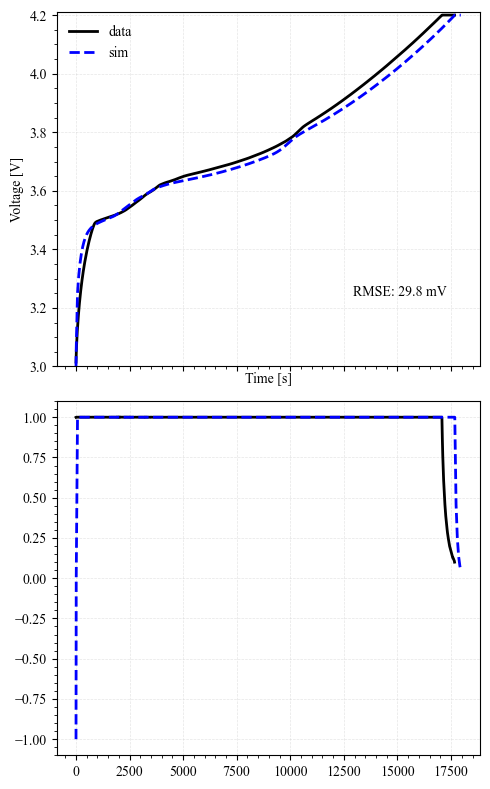

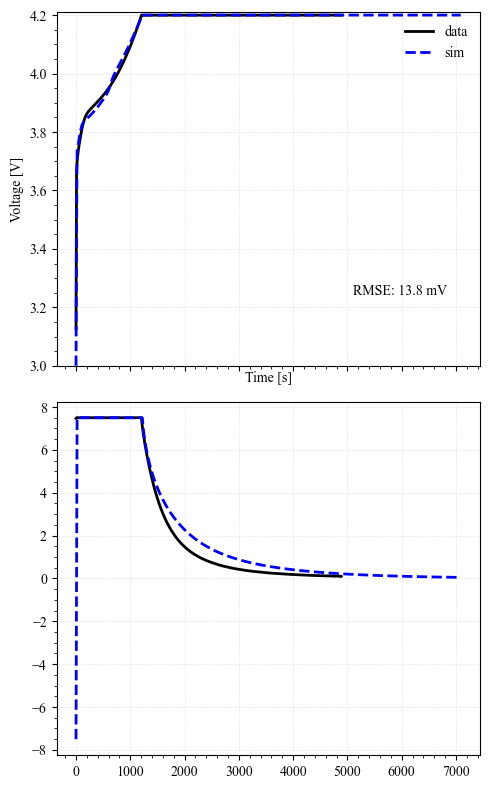

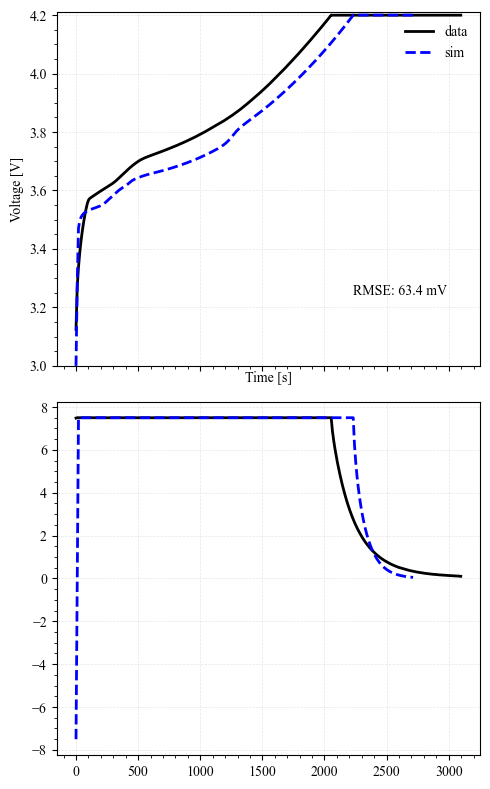

In [56]:
# cells = [3,6,9]
cells = [2,3,5,6]
for cell in cells:
    rmse_V=model_error(cell,parameter_values,plot_bool=True)

# END